# 13.11. 全卷积网络
如[13.9](./L13_9_语义分割和数据集.ipynb)中所介绍的那样，**语义分割是对图像中的每个像素分类**。

**全卷积网络**（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 。与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络**将中间层特征图的高和宽变换回输入图像的尺寸**：这是通过在[13.10](./L13_10_转置卷积.ipynb)中引入的**转置卷积**（transposed convolution）实现的。因此，输出的类别预测与输入图像在**像素级别**上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。

## 13.11.1. 构造模型
下面我们了解一下全卷积网络模型最基本的设计。如[图13.11.1](../img/13_13.png)所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后在[13.10节](./L13_10_转置卷积.ipynb)中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

![全卷积网络](../img/13_13.png)

下面，我们**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**，并将该网络记为`pretrained_net`。ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

pretrained_net=torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

list(pretrained_net.children())[-3:]  # 查看最后3层的网络架构


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
"""
接下来，我们创建一个全卷积网络net。 它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。
"""
net=nn.Sequential(*list(pretrained_net.children()))[:-2]

In [4]:
"""
给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的1/32，即10和15。
"""
X=torch.rand(size=(1,3,320,480))
X,net(X).shape

(tensor([[[[0.7331, 0.7088, 0.8614,  ..., 0.2095, 0.2529, 0.5869],
           [0.0276, 0.3073, 0.7810,  ..., 0.4874, 0.0428, 0.4324],
           [0.0671, 0.5483, 0.3312,  ..., 0.6795, 0.7665, 0.5101],
           ...,
           [0.4263, 0.8407, 0.2852,  ..., 0.4919, 0.4511, 0.6898],
           [0.4166, 0.1182, 0.6424,  ..., 0.3936, 0.7412, 0.3721],
           [0.5702, 0.6451, 0.4925,  ..., 0.1763, 0.9069, 0.1441]],
 
          [[0.0066, 0.2306, 0.4929,  ..., 0.8882, 0.4756, 0.0385],
           [0.2868, 0.8798, 0.4880,  ..., 0.8482, 0.7506, 0.6463],
           [0.0121, 0.5587, 0.4501,  ..., 0.1198, 0.4795, 0.3344],
           ...,
           [0.0927, 0.2879, 0.2459,  ..., 0.8122, 0.6422, 0.5583],
           [0.5667, 0.1874, 0.0018,  ..., 0.2799, 0.4473, 0.9087],
           [0.8176, 0.5418, 0.0563,  ..., 0.3236, 0.3030, 0.2393]],
 
          [[0.6927, 0.7491, 0.5376,  ..., 0.5711, 0.8741, 0.4187],
           [0.9559, 0.6612, 0.7119,  ..., 0.7249, 0.1408, 0.3202],
           [0.8398, 0.84

接下来，我们**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）**。最后，我们需要**将特征图的高度和宽度增加32倍**，从而将其变回输入图像的高和宽。回想一下[6.3节](../chap6_卷积神经网络/L6_3_填充和步幅.ipynb)中卷积层输出形状的计算方法：由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。

In [5]:
num_classes=21
net.add_module('final_conv',nn.Conv2d(512,num_classes,kernel_size=1))
net.add_module('transpose_conv',nn.ConvTranspose2d(num_classes,num_classes,kernel_size=64,padding=16,stride=32))


## 13.11.2. 初始化转置卷积层
在图像处理中，我们有时需要将图像放大，即**上采样**（upsampling）。**双线性插值**（bilinear interpolation）是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。首先，将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。例如，根据输入与输出的尺寸之比来映射。请注意，映射后的$x′$和$y′$是实数。然后，在输入图像上找到离坐标$(x',y')$最近的4个像素。最后，输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造。限于篇幅，我们只给出`bilinear_kernel`函数的实现，不讨论算法的原理。


input image shape torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


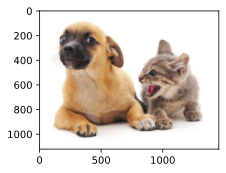

In [6]:
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1) // 2
    if kernel_size % 2 == 1:
        center=factor-1
    else:
        center=factor-0.5
    og = (torch.arange(kernel_size).reshape(-1,1),
        torch.arange(kernel_size).reshape(1,-1))
    filt = (1-torch.abs(og[0]-center) / factor ) * (1-torch.abs(og[1]-center) / factor )
    weight=torch.zeros((in_channels,out_channels,kernel_size,kernel_size))
    weight[range(in_channels),range(out_channels),:,:]=filt
    return weight

"""
让我们用双线性插值的上采样实验它由转置卷积层实现。 我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用bilinear_kernel函数初始化。
"""
conv_trans=nn.ConvTranspose2d(3,3,kernel_size=4,padding=1,stride=2,bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3,3,4))

"""
读取图像X，将上采样的结果记作Y。为了打印图像，我们需要调整通道维的位置。
"""
img=torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X=img.unsqueeze(0)
Y=conv_trans(X)
out_img=Y[0].permute(1,2,0).detach()

"""
可以看到，转置卷积层将图像的高和宽分别放大了2倍。 除了坐标刻度不同，双线性插值放大的图像和在 13.3节中打印出的原图看上去没什么两样。
"""
d2l.set_figsize()
print('input image shape',img.permute(1,2,0).shape)
d2l.plt.imshow(img.permute(1,2,0))
print('output image shape:',out_img.shape)
d2l.plt.imshow(out_img)

In [7]:
"""
在全卷积网络中，我们用双线性插值的上采样初始化转置卷积层。
对于1x1卷积层，我们使用Xavier初始化参数。
"""
W=bilinear_kernel(num_classes,num_classes,64)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

## 13.11.3. 读取数据集
我们用[13.9节](./L13_9_语义分割和数据集.ipynb)中介绍的语义分割读取数据集。指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。

In [10]:
batch_size,crop_size=16,(320,480)
train_iter,test_iter=d2l.load_data_voc(batch_size,crop_size)

read 1114 examples
read 1078 examples


## 13.11.4. 训练
现在我们可以训练全卷积网络了。这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，**因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维**。此外，模型基于每个像素的预测类别是否正确来计算准确率。

RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 3.81 GiB total capacity; 2.35 GiB already allocated; 129.31 MiB free; 2.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

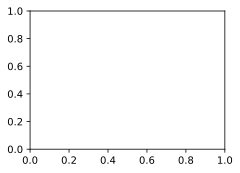

In [12]:
def loss(inputs,targets):
    return F.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)
num_epochs,lr,wd,devices=5,0.001,1e-3,d2l.try_all_gpus()

trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=wd)


"""
loss 0.426, train acc 0.868, test acc 0.853
46.5 examples/sec on [device(type='cuda', index=0)]
"""
d2l.train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices)



## 13.11.5. 预测

In [ ]:
"""
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。
"""
def predict(img):
    X=test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred=net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1],pred.shape[2])

"""
为了可视化预测的类别给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。
"""
def label2image(pred):
    colormap=torch.tensor(d2l.VOC_COLORMAP,devices=devices[0])
    X=pred.long()
    return colormap[X,:]


测试数据集中的图像大小和形状各异。 由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。 为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。 请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。 对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。

In [1]:
voc_dir=d2l.download_extract('voc2012','VOCdevkit/VOC2012')
test_images,test_labels=d2l.read_voc_images(voc_dir,False)
n,imgs=4,[]
for i in range(n):
    crop_rect=(0,0,320,480)
    X=torchvision.transforms.functional.crop(test_images[i],*crop_rect)
    pred=label2image(predict(X))
    imgs += [X.permute(1,2,0),pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i],*crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3]+imgs[1::3]+imgs[2::3],3,n,scale=2)

NameError: name 'd2l' is not defined

## 13.11.6. 小结
- 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。

- 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。